### Load the data

In [5]:
import pyxdf
import mne
import mne_connectivity
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.signal import sosfiltfilt, butter, hilbert
from scipy import io
from scipy.stats import pearsonr
from scipy.io import loadmat

from pingouin import circ_corrcl

import seaborn as sns

import neurodsp
from neurodsp import spectral
from neurodsp import filt
from neurodsp import sim

import fooof
from fooof import FOOOF
from fooof import FOOOFGroup
#from fooof.plts.templates import plot_spectrum
from sklearn.decomposition import PCA
import scipy

#data = np.load(r'C:\Users\jaket\COGS280\DataDeco\eeg.npy')

behavior = pd.read_csv(r'C:\Users\jaket\COGS280\DataDeco\behavior.csv', index_col=0).reset_index(drop=True)

prestim_ref_mat = scipy.io.loadmat(r'C:\Users\jaket\COGS280\DataDeco\FowRev_long_192to255_tau5.mat')['ref_mats']
behavior['trial'] = behavior.index
behavior['prestim_ref_mat'] = [prestim_ref_mat[i] for i in range(prestim_ref_mat.shape[0])]
#list1 = [Ref_matrices_array[i] for i in range(Ref_matrices_array.shape[0])]
behavior['Ref_matrices'] = behavior['prestim_ref_mat']
behavior.head()

,subject,drug,session,block,miniblock,trial_nr,cue,location,cue_val,stimulus,response,correct,RT,total_trial,bl_pupil,bl_pupil_bin,trial,prestim_ref_mat,Ref_matrices
0,1,DNP,0,1,0,316,1,1,1,1,1,1,700.413423,0,4357.233196,4,0,"[[0.0, 0.0006873881373122065, 0.00016213735834...","[[0.0, 0.0006873881373122065, 0.00016213735834..."
1,1,DNP,0,1,0,318,1,1,1,1,1,1,625.350154,1,4399.359772,4,1,"[[0.0, 0.040240608719263854, 0.000460120231847...","[[0.0, 0.040240608719263854, 0.000460120231847..."
2,1,DNP,0,1,0,319,0,1,0,1,1,1,775.374966,2,4523.822666,4,2,"[[0.0, 0.00011810852016698719, 1.5823859782963...","[[0.0, 0.00011810852016698719, 1.5823859782963..."
3,1,DNP,0,1,0,320,1,1,1,1,1,1,700.344298,3,4433.337541,4,3,"[[0.0, 6.157323424213391e-05, 0.00035627791271...","[[0.0, 6.157323424213391e-05, 0.00035627791271..."
4,1,DNP,0,1,0,321,1,1,1,0,1,0,775.313991,4,4296.816038,3,4,"[[0.0, 0.005253544828395134, 0.001778205067022...","[[0.0, 0.005253544828395134, 0.001778205067022..."


# IGNORE

### Testing

In [ ]:
 # Replace with your data
montage = mne.channels.make_standard_montage('biosemi64')
channel_names = montage.ch_names
channel_locs = montage.get_positions()['ch_pos']
info = mne.create_info(channel_names, sfreq=128, ch_types='eeg')
info.set_montage(montage) # Adjust accordingly

epocharray = mne.EpochsArray(data, info)

In [ ]:
import plotly.graph_objects as go
import mne

from scipy.spatial import distance_matrix
from scipy.stats import zscore

# Assuming 'montage' is your montage object
# And 'info' has been set up with this montage
montage = mne.channels.make_standard_montage('biosemi64')
# Extract positions
pos = montage.get_positions()['ch_pos']
positions = np.array(list(pos.values()))
dist_matrix = distance_matrix(positions, positions)

min_threshold = np.percentile(dist_matrix, 95) 
filtered_indices = []
filtered_values = []

for i in range(len(positions)):
    for j in range(i + 1, len(positions)):
        if dist_matrix[i, j] >= min_threshold:
            filtered_indices.append((i, j))
            filtered_values.append(avg_refmatrix[i, j])

# Step 2: Calculate z-scores for the filtered values
z_scores_filtered = zscore(filtered_values)

# Create a Plotly scatter3d plot
fig = go.Figure()

# Add scatter plot for electrode positions
fig.add_trace(go.Scatter3d(x=[pos[key][0] for key in pos],
                           y=[pos[key][1] for key in pos],
                           z=[pos[key][2] for key in pos],
                           mode='markers+text',
                           text=list(pos.keys()),
                           textposition="top center",
                           marker=dict(size=4, color='red')))

for idx, (i, j) in enumerate(filtered_indices):
    z_score = z_scores_filtered[idx]
    
    # Modulate line opacity based on z-score
    opacity = (z_score - np.min(z_scores_filtered)) / (np.max(z_scores_filtered) - np.min(z_scores_filtered))  # Normalize to [0, 1  # Ensure opacity stays within a visible range
    
    fig.add_trace(go.Scatter3d(
        x=[positions[i, 0], positions[j, 0]],
        y=[positions[i, 1], positions[j, 1]],
        z=[positions[i, 2], positions[j, 2]],
        mode='lines',
        line=dict(color=f'rgba(0, 0, 255, {opacity})', width=2),  # Adjust color/width as needed
        showlegend=False
    ))

# Update layout for better visualization
fig.update_layout(scene=dict(xaxis_title='X',
                             yaxis_title='Y',
                             zaxis_title='Z'),
                  width=800,
                  height=700,
                  margin=dict(l=0, r=0, b=0, t=0))

fig.show()


In [ ]:
# Visualize the montage
data1 = data[0,:,:]  # Replace with your data
montage = mne.channels.make_standard_montage('biosemi64')
channel_names = montage.ch_names
channel_locs = montage.get_positions()['ch_pos']
info = mne.create_info(channel_names, sfreq=128, ch_types='eeg')
info.set_montage(montage) # Adjust accordingly
raw = mne.io.RawArray(data1, info, verbose = False)

# Set montage if known
montage = mne.channels.make_standard_montage('biosemi64')

fig = mne.viz.plot_montage(montage, show_names=True)

raw.plot_sensors(kind='3d', show_names=True)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

avg_refmatrix = np.mean(behavior['Ref_matrices'])

# Flatten the array
flat_array = avg_refmatrix.flatten()
# Calculate the threshold for the top % of values
threshold = np.percentile(flat_array, 99.9)
# Find the indexes of the values that are in the top %
indexes = np.where(flat_array >= threshold)
# Convert these indexes back to 2D format
top_5_percent_indexes = np.unravel_index(indexes, avg_refmatrix.shape)

channels = ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3',
	'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1',
	'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz',
	'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4',
	'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4',
	'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8',
	'P10', 'PO8', 'PO4', 'O2']

n_channels = len(channels)

rows = top_5_percent_indexes[0][0]
cols = top_5_percent_indexes[1][0]

unique_pairs = []
unique_array1 = []
unique_array2 = []

# Check each pair and add it if its sorted version is not already in unique_pairs
for a, b in zip(rows, cols):
    pair_sorted = tuple(sorted((a, b)))
    if pair_sorted not in unique_pairs:
        unique_pairs.append(pair_sorted)
        unique_array1.append(a)
        unique_array2.append(b)

# Convert lists back to arrays
unique_array1 = np.array(unique_array1)
unique_array2 = np.array(unique_array2)
# Print the unique arrays preserving the order
    
print('Top Unique Pairs:')
    
for pair in range(len(unique_array1)):
    print(channels[unique_array1[pair]] + ',' + channels[unique_array2[pair]])
    
print('')

print("Max value: ", np.max(avg_refmatrix))

montage = mne.channels.make_standard_montage('biosemi64')

channel_names = montage.ch_names

# Get the positions of the electrodes
pos = montage.get_positions()['ch_pos']  # This returns a dictionary mapping channel names to 3D positions

positions = np.array(list(pos.values()))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot electrode locations
for idx, (name, coordinate) in enumerate(montage.get_positions()['ch_pos'].items()):
    ax.scatter(coordinate[0], coordinate[1], coordinate[2], c='r', marker='o', s=50)
    ax.text(coordinate[0], coordinate[1], coordinate[2], name, fontsize=9)

min_threshold = np.percentile(avg_refmatrix, 95)  # example threshold for top 5% of connections

for i in range(n_channels):
    for j in range(i + 1, n_channels):  # Avoid duplicating lines
        avg_refmatrix1 = avg_refmatrix[i, j]
        if avg_refmatrix1 > min_threshold:
            # Calculate line thickness based on connectivity strength
            # This scaling factor can be adjusted as needed
            linewidth = (avg_refmatrix1 - min_threshold) * 300
            
            # Draw the line
            ax.plot([positions[i, 0], positions[j, 0]], [positions[i, 1], positions[j, 1]], [positions[i, 2], positions[j, 2]], 'b', linewidth=linewidth)


In [ ]:
### THIS IS JUST A VISUALIZATION OF ALPHA POWER FOR THE ENTIRE FIRST TRIAL


# Assuming data is your EEG data array of shape (64, 166)
data1 = data[0,:,:]  # Replace with your data

channel_names = mne.channels.make_standard_montage('biosemi64').ch_names
channel_locs = mne.channels.make_standard_montage('biosemi64').get_positions()['ch_pos']


info = mne.create_info(channel_names, sfreq=128, ch_types='eeg')  # Adjust accordingly
raw = mne.io.RawArray(data1, info, verbose = False)

# Set montage if known
montage = mne.channels.make_standard_montage('biosemi64')
raw.set_montage(montage)

# Compute PSD
psds, freqs = mne.time_frequency.psd_welch(raw, fmin=8, fmax=12, n_per_seg=128, verbose = False)

# Average PSDs across the alpha band frequencies to get alpha power
alpha_power = psds.mean(axis=1)


# Plot topomap
mne.viz.plot_topomap(alpha_power, raw.info)

[0. 0. 0. 0. 0.]
[[2.77333912e-32 2.79140854e-03 2.35837016e-04 ... 3.91987911e-03
  4.35943576e-03 3.28126379e-04]
 [2.79140854e-03 0.00000000e+00 1.08634492e-03 ... 1.59186247e-02
  1.37861343e-02 1.25482402e-03]
 [2.35837016e-04 1.08634492e-03 0.00000000e+00 ... 3.00912352e-03
  1.66081762e-03 6.71298030e-04]
 ...
 [3.91987911e-03 1.59186247e-02 3.00912352e-03 ... 0.00000000e+00
  3.56253655e-04 8.27459089e-02]
 [4.35943576e-03 1.37861343e-02 1.66081762e-03 ... 3.56253655e-04
  2.77333912e-32 1.12342303e-01]
 [3.28126379e-04 1.25482402e-03 6.71298030e-04 ... 8.27459089e-02
  1.12342303e-01 0.00000000e+00]]
Indexes of the top 5% values: (array([[11, 11, 21, 21, 24]], dtype=int64), array([[21, 24, 11, 47, 11]], dtype=int64))
64
[11 11 21 21 24]
[21 24 11 47 11]
C1,P5
[1.20583902e-02 1.86880692e-02 5.63669343e-03 3.52144945e-05
 9.29816976e-05 1.34865329e-03 3.15641436e-04 9.90798801e-05
 2.38792005e-03 7.61779615e-02 5.37642119e-02 0.00000000e+00
 1.62383839e-04 1.73917911e-03 4.93872

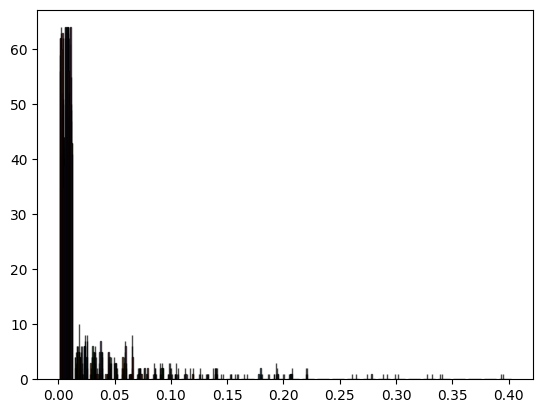

In [ ]:
#TESTING -- this one is just exploring that channel x channel matrix
tau = 5
i = 0
j = 0
trial = 0
fs = 128
prestimulus_timepoints = 64
time_points = len(data[0,0,:])
number_trials = len(data[:,-1,-1])

irrev_array = np.zeros(number_trials)

n_channels = len(data[0,:,0])

Forw = np.zeros((n_channels, n_channels))
Rev = np.zeros((n_channels, n_channels))
Diff = np.zeros((n_channels, n_channels))

#prestimulus irreversibilities
for trial in range(150,151):
  forw_data = data[trial,:,0:prestimulus_timepoints]
  rev_data = np.flip(forw_data, 1)
  for i in range(n_channels):
    for j in range(n_channels):
      x = pearsonr(forw_data[i,0:prestimulus_timepoints-tau], forw_data[j,tau:prestimulus_timepoints])
      y = pearsonr(rev_data[i,0:prestimulus_timepoints-tau], rev_data[j,tau:prestimulus_timepoints])
      Forw[i,j] = x[0]
      Rev[i,j] = y[0]
  Forw = -1/2 * np.log(1 - (Forw**2))
  Rev = -1/2 * np.log(1 - (Rev**2))
  Diff = (Forw - Rev)**2
  i = np.mean(Diff)
  irrev_array[trial] = i
  
############
print(irrev_array[0:5])
print(Diff)

# Flatten the array
flat_array = Diff.flatten()

# Calculate the threshold for the top 5% of values
threshold = np.percentile(flat_array, 99.9)

# Find the indexes of the values that are in the top 5%
indexes = np.where(flat_array >= threshold)

# Convert these indexes back to 2D format
top_5_percent_indexes = np.unravel_index(indexes, Diff.shape)

# Print the indexes
print("Indexes of the top 5% values:", top_5_percent_indexes)

channels = ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3',
	'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1',
	'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz',
	'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4',
	'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4',
	'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8',
	'P10', 'PO8', 'PO4', 'O2']

rows = top_5_percent_indexes[0][0]
cols = top_5_percent_indexes[1][0]

print(len(channels))
print(rows)
print(cols)


for pair in range(len(rows)):
    print(channels[rows[pair]] + ',' + channels[cols[pair]])
    print(Diff[rows[pair]])

print(np.max(Diff))

plt.hist(Diff, bins=30, edgecolor='k', alpha=0.7)
plt.show()

### Creation of ref matrix array

In [ ]:
#LONG RUNTIME

tau = 5
i = 0
j = 0
trial = 0
fs = 128
prestimulus_timepoints = 64
time_points = len(data[0,0,:])
number_trials = len(data[:,-1,-1])

n_channels = len(data[0,:,0])

Forw = np.zeros((n_channels, n_channels))
Rev = np.zeros((n_channels, n_channels))
ref_matrix = np.zeros((n_channels, n_channels))
Ref_matrices = []

#prestimulus irreversibility ref matrices
for trial in range(number_trials):
  forw_data = data[trial,:,0:prestimulus_timepoints]
  rev_data = np.flip(forw_data, 1)
  for i in range(n_channels):
    for j in range(n_channels):
      x = pearsonr(forw_data[i,0:prestimulus_timepoints-tau], forw_data[j,tau:prestimulus_timepoints])
      y = pearsonr(rev_data[i,0:prestimulus_timepoints-tau], rev_data[j,tau:prestimulus_timepoints])
      Forw[i,j] = x[0]
      Rev[i,j] = y[0]
  Forw = -1/2 * np.log(1 - (Forw**2))
  Rev = -1/2 * np.log(1 - (Rev**2))
  ref_matrix = (Forw - Rev)**2
  Ref_matrices.append(ref_matrix)

Ref_matrices_array = np.array(Ref_matrices)

############ REFERENCE MATRIX
np.save(r'C:\Users\jaket\COGS280\DataDeco\ref_matrices.npy', Ref_matrices_array)
##################### saved

KeyboardInterrupt: 

# Working on ref matrices

Top Unique Pairs:
P4,PO8
P6,PO8
P6,O2

Max value:  0.017532782516496488


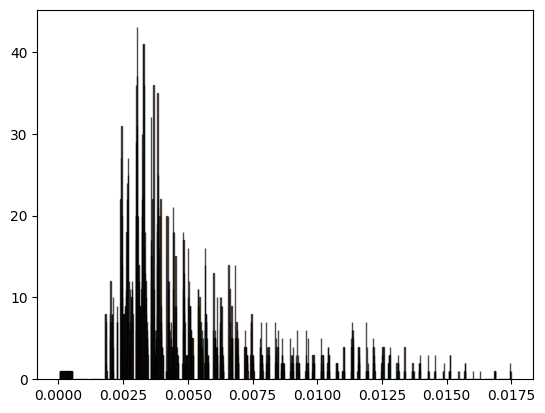

0.01669438948090061
0.01749406963015836
0.017532782516496488


In [8]:
avg_refmatrix = np.mean(behavior['Ref_matrices'])

#####
# Flatten the array
flat_array = avg_refmatrix.flatten()
# Calculate the threshold for the top % of values
threshold = np.percentile(flat_array, 99.9)
# Find the indexes of the values that are in the top %
indexes = np.where(flat_array >= threshold)
# Convert these indexes back to 2D format
top_5_percent_indexes = np.unravel_index(indexes, avg_refmatrix.shape)

channels = ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3',
	'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1',
	'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz',
	'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4',
	'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4',
	'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8',
	'P10', 'PO8', 'PO4', 'O2']

rows = top_5_percent_indexes[0][0]
cols = top_5_percent_indexes[1][0]

unique_pairs = []
unique_array1 = []
unique_array2 = []

# Check each pair and add it if its sorted version is not already in unique_pairs
for a, b in zip(rows, cols):
    pair_sorted = tuple(sorted((a, b)))
    if pair_sorted not in unique_pairs:
        unique_pairs.append(pair_sorted)
        unique_array1.append(a)
        unique_array2.append(b)

# Convert lists back to arrays
unique_array1 = np.array(unique_array1)
unique_array2 = np.array(unique_array2)
# Print the unique arrays preserving the order
    
print('Top Unique Pairs:')
    
for pair in range(len(unique_array1)):
    print(channels[unique_array1[pair]] + ',' + channels[unique_array2[pair]])
    
print('')

print("Max value: ", np.max(avg_refmatrix))

plt.hist(avg_refmatrix, bins=30, edgecolor='k', alpha=0.7)
plt.show()

#This checks the irr value for these pairs
print(avg_refmatrix[channels.index('P4'),channels.index('PO8')])
print(avg_refmatrix[channels.index('P6'),channels.index('PO8')])
print(avg_refmatrix[channels.index('P6'),channels.index('O2')])

### abs diff between correct and incorrect

Top Unique Pairs:
PO3,Pz
POz,O2
P10,PO8

Max value:  0.002375786535953982


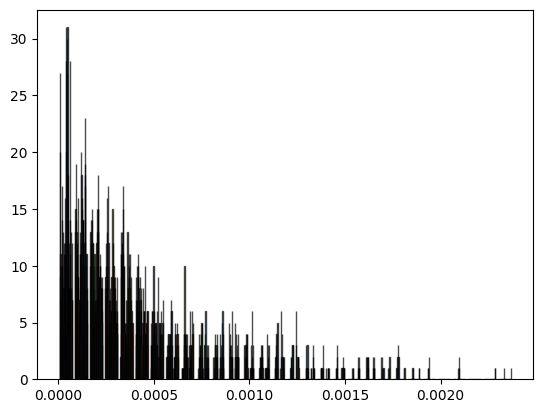

0.0021297848865980146
0.002375786535953975
0.002283816292728006


In [10]:

correct_df = behavior[(behavior['correct'] == 1)]
mean_correct_refmatrix = np.mean(correct_df['Ref_matrices'])
incorrect_df = behavior[(behavior['correct'] == 0)]
mean_incorrect_refmatrix = np.mean(incorrect_df['Ref_matrices'])

absolute_diff_matrix = np.abs(mean_correct_refmatrix - mean_incorrect_refmatrix)

#####
# Flatten the array
flat_array = absolute_diff_matrix.flatten()
# Calculate the threshold for the top % of values
threshold = np.percentile(flat_array, 99.9)
# Find the indexes of the values that are in the top %
indexes = np.where(flat_array >= threshold)
# Convert these indexes back to 2D format
top_5_percent_indexes = np.unravel_index(indexes, absolute_diff_matrix.shape)

channels = ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3',
	'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1',
	'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz',
	'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4',
	'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4',
	'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8',
	'P10', 'PO8', 'PO4', 'O2']

rows = top_5_percent_indexes[0][0]
cols = top_5_percent_indexes[1][0]

unique_pairs = []
unique_array1 = []
unique_array2 = []

# Check each pair and add it if its sorted version is not already in unique_pairs
for a, b in zip(rows, cols):
    pair_sorted = tuple(sorted((a, b)))
    if pair_sorted not in unique_pairs:
        unique_pairs.append(pair_sorted)
        unique_array1.append(a)
        unique_array2.append(b)

# Convert lists back to arrays
unique_array1 = np.array(unique_array1)
unique_array2 = np.array(unique_array2)
# Print the unique arrays preserving the order
    
print('Top Unique Pairs:')
    
for pair in range(len(unique_array1)):
    print(channels[unique_array1[pair]] + ',' + channels[unique_array2[pair]])
    
print('')

print("Max value: ", np.max(absolute_diff_matrix))

plt.hist(absolute_diff_matrix, bins=30, edgecolor='k', alpha=0.7)
plt.show()

#This checks the irr value for these pairs
print(absolute_diff_matrix[channels.index('PO3'),channels.index('Pz')])
print(absolute_diff_matrix[channels.index('POz'),channels.index('O2')])
print(absolute_diff_matrix[channels.index('P10'),channels.index('PO8')])

In [11]:
print("Pairwise Irrev Between " + "POz " + "And " + "O2" + "= " + str(absolute_diff_matrix[channels.index('POz'),channels.index('O2')]))
print("Pairwise Irrev Between " + "POz " + "And " + "O1" + "= " + str(absolute_diff_matrix[channels.index('POz'),channels.index('O1')]))
print("Pairwise Irrev Between " + "POz " + "And " + "Oz" + "= " + str(absolute_diff_matrix[channels.index('POz'),channels.index('Oz')]))
print()
print("Pairwise Irrev Between " + "Fpz " + "And " + "Cz" + "= " + str(absolute_diff_matrix[channels.index('Fpz'),channels.index('Cz')]))
print("Pairwise Irrev Between " + "Fpz " + "And " + "Oz" + "= " + str(absolute_diff_matrix[channels.index('Fpz'),channels.index('Oz')]))
print("Pairwise Irrev Between " + "POz " + "And " + "O2" + "= " + str(absolute_diff_matrix[channels.index('POz'),channels.index('O2')]))
print("Pairwise Irrev Between " + "POz " + "And " + "O2" + "= " + str(absolute_diff_matrix[channels.index('POz'),channels.index('O2')]))


Pairwise Irrev Between POz And O2= 0.002375786535953975
Pairwise Irrev Between POz And O1= 0.0019713809867116933
Pairwise Irrev Between POz And Oz= 0.0017969681173690619

Pairwise Irrev Between Fpz And Cz= 5.631249272453672e-05
Pairwise Irrev Between Fpz And Oz= 1.4791957924917883e-05
Pairwise Irrev Between POz And O2= 0.002375786535953975
Pairwise Irrev Between POz And O2= 0.002375786535953975


# Topoplots

## total avg refmatrix

In [6]:
#This is a topoplot of the channel by channel contribution to the total average reference matrix


channels = ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3',
	'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1',
	'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz',
	'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4',
	'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4',
	'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8',
	'P10', 'PO8', 'PO4', 'O2']

data1 = data[0,:,:]  # Replace with your data
montage = mne.channels.make_standard_montage('biosemi64')
channel_names = montage.ch_names
channel_locs = montage.get_positions()['ch_pos']
info = mne.create_info(channel_names, sfreq=128, ch_types='eeg')
info.set_montage(montage) # Adjust accordingly
raw = mne.io.RawArray(data1, info, verbose = False)

info = mne.create_info(channel_names, sfreq=128, ch_types='eeg')  # Adjust accordingly
raw = mne.io.RawArray(data1, info, verbose = False)

# Set montage if known
montage = mne.channels.make_standard_montage('biosemi64')
raw.set_montage(montage)

avg_refmatrix = np.mean(behavior['Ref_matrices'])

from scipy.stats import zscore

row = []
col = []

for r in range(64):
    i = np.mean(avg_refmatrix[r,:])
    row.append(i)
row = np.array(row)

for c in range(64):
    i = np.mean(avg_refmatrix[:,c])
    col.append(i)
col = np.array(col)

channel_contribution = row + col

print(channel_contribution.shape)

zscore_matrix = zscore(channel_contribution, axis=None)

max = np.max(channel_contribution)

print("Max channel contribution: " + str(channels[np.argmax(channel_contribution)]) + ": " + str(max))

max = np.max(avg_refmatrix)

print("Max Pairwise Irreversibility: " + str(channels[np.unravel_index(np.argmax(avg_refmatrix), avg_refmatrix.shape)[0]]) + "/" + 
      str(channels[np.unravel_index(np.argmax(avg_refmatrix), avg_refmatrix.shape)[1]])+  ": " + str(max))

mne.viz.plot_topomap(channel_contribution, raw.info, res = 400, size = 3)

mne.viz.plot_topomap(zscore_matrix, raw.info, res = 400, size = 3)


NameError: name 'data' is not defined

## diff correct/incorrect

difference btw correct vs. incorrect

Correct:
Max channel contribution: PO8: 0.014454191073841965
Max Pairwise Irreversibility: P6/O2: 0.01783283517576993


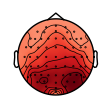

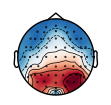

Incorrect:
Max channel contribution: PO8: 0.015607244026173542
Max Pairwise Irreversibility: P4/PO8: 0.01783283517576993


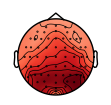

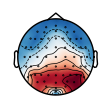

Absolute Difference:
Max channel difference: POz: 0.01783283517576993


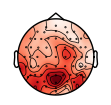

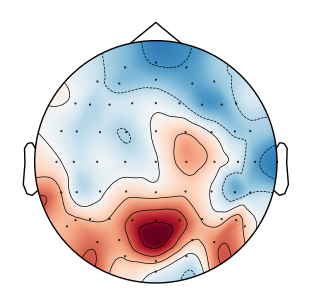

Difference correct - incorrect: 


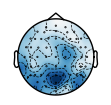

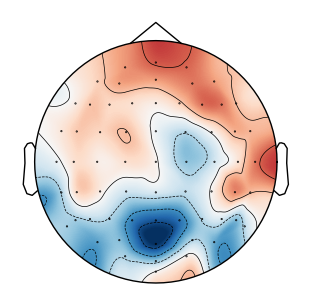

(<matplotlib.image.AxesImage at 0x288654a2970>,
 <matplotlib.contour.QuadContourSet at 0x288654a2cd0>)

In [23]:
#This is a topoplot of the channel by channel contribution to correct and incorrect respectively
behavior = pd.read_csv(r'C:\Users\jaket\COGS280\DataDeco\behavior.csv', index_col=0).reset_index(drop=True)
Ref_matrices_array = np.load(r'C:\Users\jaket\COGS280\DataDeco\prestimulus_ref_matrices.npy')
behavior['trial'] = behavior.index
list1 = [Ref_matrices_array[i] for i in range(Ref_matrices_array.shape[0])]
behavior['Ref_matrices'] = list1


correct_df = behavior[(behavior['correct'] == 1)]
mean_correct_refmatrix = np.mean(correct_df['Ref_matrices'])
incorrect_df = behavior[(behavior['correct'] == 0)]
mean_incorrect_refmatrix = np.mean(incorrect_df['Ref_matrices'])

print("Correct:")
row = []
col = []

for r in range(64):
    i = np.mean(mean_correct_refmatrix[r,:])
    row.append(i)
row = np.array(row)

for c in range(64):
    i = np.mean(mean_correct_refmatrix[:,c])
    col.append(i)
col = np.array(col)

channel_contribution1 = row + col

max = np.max(channel_contribution1)

print("Max channel contribution: " + str(channels[np.argmax(channel_contribution1)]) + ": " + str(max))

max = np.max(mean_correct_refmatrix)

print("Max Pairwise Irreversibility: " + str(channels[np.unravel_index(np.argmax(mean_correct_refmatrix), mean_correct_refmatrix.shape)[0]]) + "/" + 
      str(channels[np.unravel_index(np.argmax(mean_correct_refmatrix), mean_correct_refmatrix.shape)[1]])+  ": " + str(max))

mne.viz.plot_topomap(channel_contribution1, raw.info)
zscore_matrix = zscore(channel_contribution1, axis=None)
mne.viz.plot_topomap(zscore_matrix, raw.info)

###################
print("Incorrect:")
row = []
col = []

for r in range(64):
    i = np.mean(mean_incorrect_refmatrix[r,:])
    row.append(i)
row = np.array(row)

for c in range(64):
    i = np.mean(mean_incorrect_refmatrix[:,c])
    col.append(i)
col = np.array(col)

channel_contribution2 = row + col

max = np.max(channel_contribution2)

print("Max channel contribution: " + str(channels[np.argmax(channel_contribution2)]) + ": " + str(max))

max = np.max(mean_correct_refmatrix)

print("Max Pairwise Irreversibility: " + str(channels[np.unravel_index(np.argmax(mean_incorrect_refmatrix), mean_incorrect_refmatrix.shape)[0]]) + "/" + 
      str(channels[np.unravel_index(np.argmax(mean_incorrect_refmatrix), mean_incorrect_refmatrix.shape)[1]])+  ": " + str(max))

mne.viz.plot_topomap(channel_contribution2, raw.info)
zscore_matrix = zscore(channel_contribution2, axis=None)
mne.viz.plot_topomap(zscore_matrix, raw.info)

#############
print("Absolute Difference:")
diff_channel_contribution = np.abs(channel_contribution1 - channel_contribution2)
print("Max channel difference: " + str(channels[np.argmax(diff_channel_contribution)]) + ": " + str(max))
mne.viz.plot_topomap(diff_channel_contribution, raw.info)
zscore_matrix = zscore(diff_channel_contribution, axis=None)
mne.viz.plot_topomap(zscore_matrix, raw.info, res = 400, size = 3)
print("Difference correct - incorrect: ")
mne.viz.plot_topomap((channel_contribution1-channel_contribution2), raw.info)
diff_channel_contribution = (channel_contribution1 - channel_contribution2)
zscore_matrix = zscore(diff_channel_contribution, axis=None)
mne.viz.plot_topomap(zscore_matrix, raw.info, res = 400, size = 3)

### by drug

PLACEBO

Correct:
Max channel contribution: PO4: 0.014328593887988152
Max Pairwise Irreversibility: PO8/P6: 0.01714417053774749


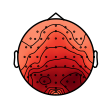

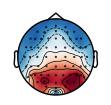

Incorrect:
Max channel contribution: PO8: 0.01615077976058195
Max Pairwise Irreversibility: P4/PO8: 0.01714417053774749


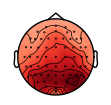

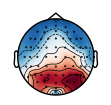

Absolute Difference:
Max channel difference: P8: 0.01714417053774749


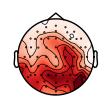

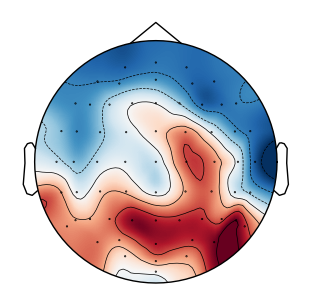

Difference correct - incorrect: 


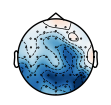

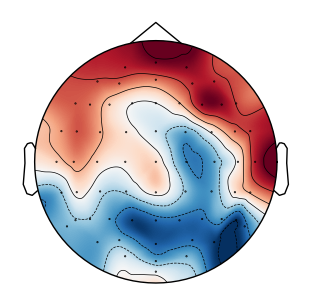

(<matplotlib.image.AxesImage at 0x28866229ee0>,
 <matplotlib.contour.QuadContourSet at 0x28865b32280>)

In [24]:
behavior = pd.read_csv(r'C:\Users\jaket\COGS280\DataDeco\behavior.csv', index_col=0).reset_index(drop=True)
Ref_matrices_array = np.load(r'C:\Users\jaket\COGS280\DataDeco\prestimulus_ref_matrices.npy')
behavior['trial'] = behavior.index
list1 = [Ref_matrices_array[i] for i in range(Ref_matrices_array.shape[0])]
behavior['Ref_matrices'] = list1

drug = 'PLC'

behavior = behavior[(behavior['drug'] == drug)]

channels = ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3',
	'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1',
	'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz',
	'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4',
	'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4',
	'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8',
	'P10', 'PO8', 'PO4', 'O2']

data1 = data[0,:,:]  # Replace with your data
montage = mne.channels.make_standard_montage('biosemi64')
channel_names = montage.ch_names
channel_locs = montage.get_positions()['ch_pos']
info = mne.create_info(channel_names, sfreq=128, ch_types='eeg')
info.set_montage(montage) # Adjust accordingly
raw = mne.io.RawArray(data1, info, verbose = False)

montage = mne.channels.make_standard_montage('biosemi64')
raw.set_montage(montage)

avg_refmatrix = np.mean(behavior['Ref_matrices'])
correct_df = behavior[(behavior['correct'] == 1)]
mean_correct_refmatrix = np.mean(correct_df['Ref_matrices'])
incorrect_df = behavior[(behavior['correct'] == 0)]
mean_incorrect_refmatrix = np.mean(incorrect_df['Ref_matrices'])

absolute_diff_matrix = np.abs(mean_correct_refmatrix - mean_incorrect_refmatrix)

from scipy.stats import zscore

print("Correct:")
row = []
col = []

for r in range(64):
    i = np.mean(mean_correct_refmatrix[r,:])
    row.append(i)
row = np.array(row)

for c in range(64):
    i = np.mean(mean_correct_refmatrix[:,c])
    col.append(i)
col = np.array(col)

channel_contribution1 = row + col

max = np.max(channel_contribution1)

print("Max channel contribution: " + str(channels[np.argmax(channel_contribution1)]) + ": " + str(max))

max = np.max(mean_correct_refmatrix)

print("Max Pairwise Irreversibility: " + str(channels[np.unravel_index(np.argmax(mean_correct_refmatrix), mean_correct_refmatrix.shape)[0]]) + "/" + 
      str(channels[np.unravel_index(np.argmax(mean_correct_refmatrix), mean_correct_refmatrix.shape)[1]])+  ": " + str(max))

mne.viz.plot_topomap(channel_contribution1, raw.info)
zscore_matrix = zscore(channel_contribution1, axis=None)
mne.viz.plot_topomap(zscore_matrix, raw.info)

###################
print("Incorrect:")
row = []
col = []

for r in range(64):
    i = np.mean(mean_incorrect_refmatrix[r,:])
    row.append(i)
row = np.array(row)

for c in range(64):
    i = np.mean(mean_incorrect_refmatrix[:,c])
    col.append(i)
col = np.array(col)

channel_contribution2 = row + col

max = np.max(channel_contribution2)

print("Max channel contribution: " + str(channels[np.argmax(channel_contribution2)]) + ": " + str(max))

max = np.max(mean_correct_refmatrix)

print("Max Pairwise Irreversibility: " + str(channels[np.unravel_index(np.argmax(mean_incorrect_refmatrix), mean_incorrect_refmatrix.shape)[0]]) + "/" + 
      str(channels[np.unravel_index(np.argmax(mean_incorrect_refmatrix), mean_incorrect_refmatrix.shape)[1]])+  ": " + str(max))

mne.viz.plot_topomap(channel_contribution2, raw.info)
zscore_matrix = zscore(channel_contribution2, axis=None)
mne.viz.plot_topomap(zscore_matrix, raw.info)

#############
print("Absolute Difference:")
diff_channel_contribution = np.abs(channel_contribution1 - channel_contribution2)
print("Max channel difference: " + str(channels[np.argmax(diff_channel_contribution)]) + ": " + str(max))
mne.viz.plot_topomap(diff_channel_contribution, raw.info)
zscore_matrix = zscore(diff_channel_contribution, axis=None)
mne.viz.plot_topomap(zscore_matrix, raw.info, size = 3)
print("Difference correct - incorrect: ")
mne.viz.plot_topomap((channel_contribution1-channel_contribution2), raw.info)
diff_channel_contribution = (channel_contribution1 - channel_contribution2)
zscore_matrix = zscore(diff_channel_contribution, axis=None)
mne.viz.plot_topomap(zscore_matrix, raw.info, res = 400, size = 3)

Donezepil

Correct:
Max channel contribution: PO8: 0.014638584974056266
Max Pairwise Irreversibility: P6/PO8: 0.020007920083067728


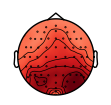

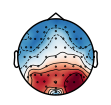

Incorrect:
Max channel contribution: PO8: 0.015792399011341086
Max Pairwise Irreversibility: P6/PO8: 0.020007920083067728


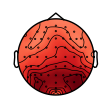

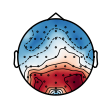

Absolute Difference:
Max channel difference: POz: 0.020007920083067728


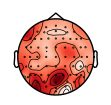

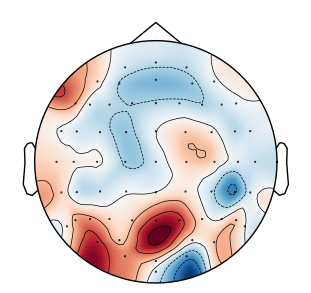

Difference correct - incorrect: 


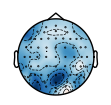

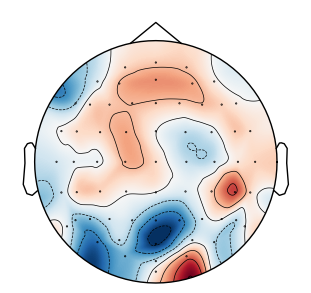

(<matplotlib.image.AxesImage at 0x288654219a0>,
 <matplotlib.contour.QuadContourSet at 0x28865421070>)

In [25]:
behavior = pd.read_csv(r'C:\Users\jaket\COGS280\DataDeco\behavior.csv', index_col=0).reset_index(drop=True)
Ref_matrices_array = np.load(r'C:\Users\jaket\COGS280\DataDeco\prestimulus_ref_matrices.npy')
behavior['trial'] = behavior.index
list1 = [Ref_matrices_array[i] for i in range(Ref_matrices_array.shape[0])]
behavior['Ref_matrices'] = list1


drug = 'DNP'

behavior = behavior[(behavior['drug'] == drug)]

channels = ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3',
	'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1',
	'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz',
	'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4',
	'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4',
	'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8',
	'P10', 'PO8', 'PO4', 'O2']

data1 = data[0,:,:]  # Replace with your data
montage = mne.channels.make_standard_montage('biosemi64')
channel_names = montage.ch_names
channel_locs = montage.get_positions()['ch_pos']
info = mne.create_info(channel_names, sfreq=128, ch_types='eeg')
info.set_montage(montage) # Adjust accordingly
raw = mne.io.RawArray(data1, info, verbose = False)

montage = mne.channels.make_standard_montage('biosemi64')
raw.set_montage(montage)

avg_refmatrix = np.mean(behavior['Ref_matrices'])
correct_df = behavior[(behavior['correct'] == 1)]
mean_correct_refmatrix = np.mean(correct_df['Ref_matrices'])
incorrect_df = behavior[(behavior['correct'] == 0)]
mean_incorrect_refmatrix = np.mean(incorrect_df['Ref_matrices'])

absolute_diff_matrix = np.abs(mean_correct_refmatrix - mean_incorrect_refmatrix)

from scipy.stats import zscore

print("Correct:")
row = []
col = []

for r in range(64):
    i = np.mean(mean_correct_refmatrix[r,:])
    row.append(i)
row = np.array(row)

for c in range(64):
    i = np.mean(mean_correct_refmatrix[:,c])
    col.append(i)
col = np.array(col)

channel_contribution1 = row + col

max = np.max(channel_contribution1)

print("Max channel contribution: " + str(channels[np.argmax(channel_contribution1)]) + ": " + str(max))

max = np.max(mean_correct_refmatrix)

print("Max Pairwise Irreversibility: " + str(channels[np.unravel_index(np.argmax(mean_correct_refmatrix), mean_correct_refmatrix.shape)[0]]) + "/" + 
      str(channels[np.unravel_index(np.argmax(mean_correct_refmatrix), mean_correct_refmatrix.shape)[1]])+  ": " + str(max))

mne.viz.plot_topomap(channel_contribution1, raw.info)
zscore_matrix = zscore(channel_contribution1, axis=None)
mne.viz.plot_topomap(zscore_matrix, raw.info)

###################
print("Incorrect:")
row = []
col = []

for r in range(64):
    i = np.mean(mean_incorrect_refmatrix[r,:])
    row.append(i)
row = np.array(row)

for c in range(64):
    i = np.mean(mean_incorrect_refmatrix[:,c])
    col.append(i)
col = np.array(col)

channel_contribution2 = row + col

max = np.max(channel_contribution2)

print("Max channel contribution: " + str(channels[np.argmax(channel_contribution2)]) + ": " + str(max))

max = np.max(mean_correct_refmatrix)

print("Max Pairwise Irreversibility: " + str(channels[np.unravel_index(np.argmax(mean_incorrect_refmatrix), mean_incorrect_refmatrix.shape)[0]]) + "/" + 
      str(channels[np.unravel_index(np.argmax(mean_incorrect_refmatrix), mean_incorrect_refmatrix.shape)[1]])+  ": " + str(max))

mne.viz.plot_topomap(channel_contribution2, raw.info)
zscore_matrix = zscore(channel_contribution2, axis=None)
mne.viz.plot_topomap(zscore_matrix, raw.info)

#############
print("Absolute Difference:")
diff_channel_contribution = np.abs(channel_contribution1 - channel_contribution2)
print("Max channel difference: " + str(channels[np.argmax(diff_channel_contribution)]) + ": " + str(max))
mne.viz.plot_topomap(diff_channel_contribution, raw.info)
zscore_matrix = zscore(diff_channel_contribution, axis=None)
mne.viz.plot_topomap(zscore_matrix, raw.info, size = 3)
print("Difference correct - incorrect: ")
mne.viz.plot_topomap((channel_contribution1-channel_contribution2), raw.info)
diff_channel_contribution = (channel_contribution1 - channel_contribution2)
zscore_matrix = zscore(diff_channel_contribution, axis=None)
mne.viz.plot_topomap(zscore_matrix, raw.info, res = 400, size = 3)

Atomoxetine

Correct:
Max channel contribution: PO4: 0.014630429157705495
Max Pairwise Irreversibility: P4/PO8: 0.017888590697883802


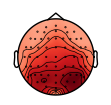

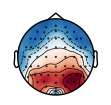

Incorrect:
Max channel contribution: PO8: 0.014792054605682661
Max Pairwise Irreversibility: PO3/PO8: 0.017888590697883802


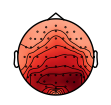

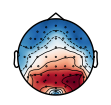

Absolute Difference:
Max channel difference: POz: 0.017888590697883802


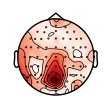

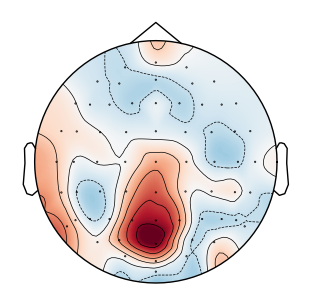

Difference correct - incorrect: 


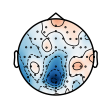

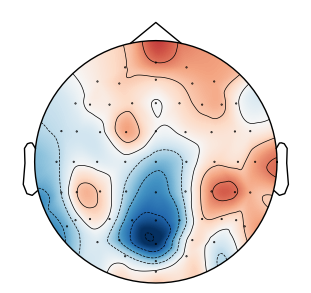

(<matplotlib.image.AxesImage at 0x28861898220>,
 <matplotlib.contour.QuadContourSet at 0x288618986d0>)

In [26]:
behavior = pd.read_csv(r'C:\Users\jaket\COGS280\DataDeco\behavior.csv', index_col=0).reset_index(drop=True)
Ref_matrices_array = np.load(r'C:\Users\jaket\COGS280\DataDeco\prestimulus_ref_matrices.npy')
behavior['trial'] = behavior.index
list1 = [Ref_matrices_array[i] for i in range(Ref_matrices_array.shape[0])]
behavior['Ref_matrices'] = list1

drug = 'ATX'

behavior = behavior[(behavior['drug'] == drug)]

channels = ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3',
	'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1',
	'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz',
	'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4',
	'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4',
	'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8',
	'P10', 'PO8', 'PO4', 'O2']

data1 = data[0,:,:]  # Replace with your data
montage = mne.channels.make_standard_montage('biosemi64')
channel_names = montage.ch_names
channel_locs = montage.get_positions()['ch_pos']
info = mne.create_info(channel_names, sfreq=128, ch_types='eeg')
info.set_montage(montage) # Adjust accordingly
raw = mne.io.RawArray(data1, info, verbose = False)

montage = mne.channels.make_standard_montage('biosemi64')
raw.set_montage(montage)

avg_refmatrix = np.mean(behavior['Ref_matrices'])
correct_df = behavior[(behavior['correct'] == 1)]
mean_correct_refmatrix = np.mean(correct_df['Ref_matrices'])
incorrect_df = behavior[(behavior['correct'] == 0)]
mean_incorrect_refmatrix = np.mean(incorrect_df['Ref_matrices'])

absolute_diff_matrix = np.abs(mean_correct_refmatrix - mean_incorrect_refmatrix)

from scipy.stats import zscore

print("Correct:")
row = []
col = []

for r in range(64):
    i = np.mean(mean_correct_refmatrix[r,:])
    row.append(i)
row = np.array(row)

for c in range(64):
    i = np.mean(mean_correct_refmatrix[:,c])
    col.append(i)
col = np.array(col)

channel_contribution1 = row + col

max = np.max(channel_contribution1)

print("Max channel contribution: " + str(channels[np.argmax(channel_contribution1)]) + ": " + str(max))

max = np.max(mean_correct_refmatrix)

print("Max Pairwise Irreversibility: " + str(channels[np.unravel_index(np.argmax(mean_correct_refmatrix), mean_correct_refmatrix.shape)[0]]) + "/" + 
      str(channels[np.unravel_index(np.argmax(mean_correct_refmatrix), mean_correct_refmatrix.shape)[1]])+  ": " + str(max))

mne.viz.plot_topomap(channel_contribution1, raw.info)
zscore_matrix = zscore(channel_contribution1, axis=None)
mne.viz.plot_topomap(zscore_matrix, raw.info)

###################
print("Incorrect:")
row = []
col = []

for r in range(64):
    i = np.mean(mean_incorrect_refmatrix[r,:])
    row.append(i)
row = np.array(row)

for c in range(64):
    i = np.mean(mean_incorrect_refmatrix[:,c])
    col.append(i)
col = np.array(col)

channel_contribution2 = row + col

max = np.max(channel_contribution2)

print("Max channel contribution: " + str(channels[np.argmax(channel_contribution2)]) + ": " + str(max))

max = np.max(mean_correct_refmatrix)

print("Max Pairwise Irreversibility: " + str(channels[np.unravel_index(np.argmax(mean_incorrect_refmatrix), mean_incorrect_refmatrix.shape)[0]]) + "/" + 
      str(channels[np.unravel_index(np.argmax(mean_incorrect_refmatrix), mean_incorrect_refmatrix.shape)[1]])+  ": " + str(max))

mne.viz.plot_topomap(channel_contribution2, raw.info)
zscore_matrix = zscore(channel_contribution2, axis=None)
mne.viz.plot_topomap(zscore_matrix, raw.info)

#############
print("Absolute Difference:")
diff_channel_contribution = np.abs(channel_contribution1 - channel_contribution2)
print("Max channel difference: " + str(channels[np.argmax(diff_channel_contribution)]) + ": " + str(max))
mne.viz.plot_topomap(diff_channel_contribution, raw.info)
zscore_matrix = zscore(diff_channel_contribution, axis=None)
mne.viz.plot_topomap(zscore_matrix, raw.info, size = 3)
print("Difference correct - incorrect: ")
mne.viz.plot_topomap((channel_contribution1-channel_contribution2), raw.info)
diff_channel_contribution = (channel_contribution1 - channel_contribution2)
zscore_matrix = zscore(diff_channel_contribution, axis=None)
mne.viz.plot_topomap(zscore_matrix, raw.info, res = 400, size = 3)

## drug condition - average

Placebo - average refmatrix
Max channel contribution: POz: 0.00040766626952580456
Max Pairwise Irreversibility: O1/PO3: 0.0013184826140211613


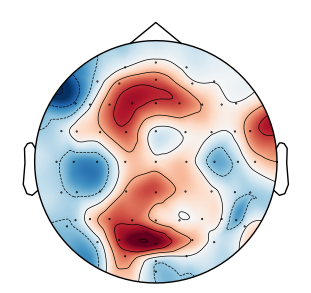

ATX - average refmatrix
Max channel contribution: C4: 0.00017894165214790743
Max Pairwise Irreversibility: PO8/POz: 0.0013184826140211613


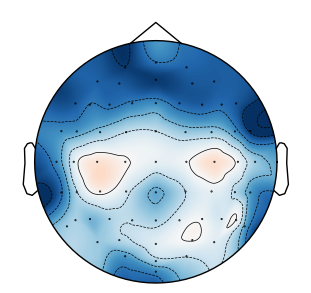

DNP - average refmatrix
Max channel contribution: F7: 0.0011491584228726706
Max Pairwise Irreversibility: P6/PO8: 0.0021937566083725865


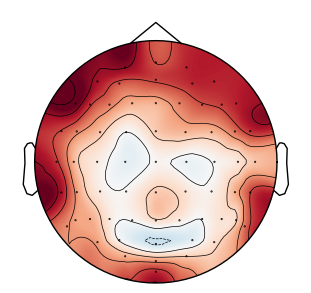

(<matplotlib.image.AxesImage at 0x28806484790>,
 <matplotlib.contour.QuadContourSet at 0x288618e7f10>)

In [27]:
behavior = pd.read_csv(r'C:\Users\jaket\COGS280\DataDeco\behavior.csv', index_col=0).reset_index(drop=True)
Ref_matrices_array = np.load(r'C:\Users\jaket\COGS280\DataDeco\prestimulus_ref_matrices.npy')
behavior['trial'] = behavior.index
list1 = [Ref_matrices_array[i] for i in range(Ref_matrices_array.shape[0])]
behavior['Ref_matrices'] = list1

avg_refmatrix = np.mean(behavior['Ref_matrices'])
placebo_refmatrix = np.mean(behavior[(behavior['drug'] == 'PLC')]['Ref_matrices']) - avg_refmatrix
atx_refmatrix = np.mean(behavior[(behavior['drug'] == 'ATX')]['Ref_matrices']) - avg_refmatrix
dnp_refmatrix = np.mean(behavior[(behavior['drug'] == 'DNP')]['Ref_matrices']) - avg_refmatrix

print("Placebo - average refmatrix")
row = []
col = []

for r in range(64):
    i = np.mean(placebo_refmatrix[r,:])
    row.append(i)
row = np.array(row)

for c in range(64):
    i = np.mean(placebo_refmatrix[:,c])
    col.append(i)
col = np.array(col)

channel_contribution = row + col

max = np.max(channel_contribution)

print("Max channel contribution: " + str(channels[np.argmax(channel_contribution)]) + ": " + str(max))

max = np.max(placebo_refmatrix)

print("Max Pairwise Irreversibility: " + str(channels[np.unravel_index(np.argmax(placebo_refmatrix), placebo_refmatrix.shape)[0]]) + "/" + 
      str(channels[np.unravel_index(np.argmax(placebo_refmatrix), placebo_refmatrix.shape)[1]])+  ": " + str(max))

mne.viz.plot_topomap(channel_contribution, raw.info, res = 400, size = 3)

print("ATX - average refmatrix")
row = []
col = []

for r in range(64):
    i = np.mean(atx_refmatrix[r,:])
    row.append(i)
row = np.array(row)

for c in range(64):
    i = np.mean(atx_refmatrix[:,c])
    col.append(i)
col = np.array(col)

channel_contribution = row + col

max = np.max(channel_contribution)

print("Max channel contribution: " + str(channels[np.argmax(channel_contribution)]) + ": " + str(max))

max = np.max(placebo_refmatrix)

print("Max Pairwise Irreversibility: " + str(channels[np.unravel_index(np.argmax(atx_refmatrix), atx_refmatrix.shape)[0]]) + "/" + 
      str(channels[np.unravel_index(np.argmax(atx_refmatrix), atx_refmatrix.shape)[1]])+  ": " + str(max))

mne.viz.plot_topomap(channel_contribution, raw.info, res = 400, size = 3)

print("DNP - average refmatrix")
row = []
col = []

for r in range(64):
    i = np.mean(dnp_refmatrix[r,:])
    row.append(i)
row = np.array(row)

for c in range(64):
    i = np.mean(dnp_refmatrix[:,c])
    col.append(i)
col = np.array(col)

channel_contribution = row + col

max = np.max(channel_contribution)

print("Max channel contribution: " + str(channels[np.argmax(channel_contribution)]) + ": " + str(max))

max = np.max(dnp_refmatrix)

print("Max Pairwise Irreversibility: " + str(channels[np.unravel_index(np.argmax(dnp_refmatrix), dnp_refmatrix.shape)[0]]) + "/" + 
      str(channels[np.unravel_index(np.argmax(dnp_refmatrix), dnp_refmatrix.shape)[1]])+  ": " + str(max))

mne.viz.plot_topomap(channel_contribution, raw.info, size = 3)

## Diff pre/post

(64,)
Max channel contribution: AFz: 0.001274523502749337
Max Pairwise Irreversibility: AFz/Oz: 0.0012143427305224275


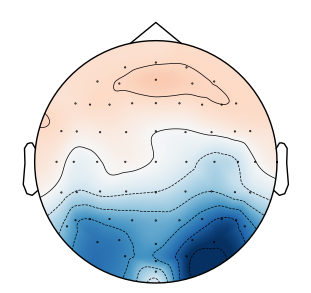

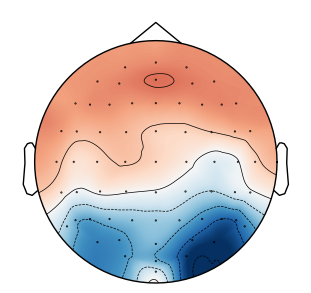

(<matplotlib.image.AxesImage at 0x27a03b59190>,
 <matplotlib.contour.QuadContourSet at 0x27a03b594f0>)

In [2]:
#This is a topoplot of the channel by channel contribution to the total average reference matrix

behavior = pd.read_csv(r'C:\Users\jaket\COGS280\DataDeco\behavior.csv', index_col=0).reset_index(drop=True)

Ref_matrices_array1 = np.load(r'C:\Users\jaket\COGS280\DataDeco\prestimulus_ref_matrices.npy')
behavior['trial'] = behavior.index
list1 = [Ref_matrices_array1[i] for i in range(Ref_matrices_array1.shape[0])]
behavior['pre_ref_matrices'] = list1

Ref_matrices_array2 = np.load(r'C:\Users\jaket\COGS280\DataDeco\poststimulus_ref_matrices.npy')
list1 = [Ref_matrices_array2[i] for i in range(Ref_matrices_array2.shape[0])]
behavior['post_ref_matrices'] = list1


channels = ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3',
	'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1',
	'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz',
	'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4',
	'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4',
	'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8',
	'P10', 'PO8', 'PO4', 'O2']

data1 = data[0,:,:]  # Replace with your data
montage = mne.channels.make_standard_montage('biosemi64')
channel_names = montage.ch_names
channel_locs = montage.get_positions()['ch_pos']
info = mne.create_info(channel_names, sfreq=128, ch_types='eeg')
info.set_montage(montage) # Adjust accordingly
raw = mne.io.RawArray(data1, info, verbose = False)

info = mne.create_info(channel_names, sfreq=128, ch_types='eeg')  # Adjust accordingly
raw = mne.io.RawArray(data1, info, verbose = False)

# Set montage if known
montage = mne.channels.make_standard_montage('biosemi64')
raw.set_montage(montage)

avg_refmatrix = (np.mean(behavior['post_ref_matrices']) - np.mean(behavior['pre_ref_matrices'])) 

from scipy.stats import zscore

row = []
col = []

for r in range(64):
    i = np.mean(avg_refmatrix[r,:])
    row.append(i)
row = np.array(row)

for c in range(64):
    i = np.mean(avg_refmatrix[:,c])
    col.append(i)
col = np.array(col)

channel_contribution = row + col

print(channel_contribution.shape)

zscore_matrix = zscore(channel_contribution, axis=None)

max = np.max(channel_contribution)

print("Max channel contribution: " + str(channels[np.argmax(channel_contribution)]) + ": " + str(max))

max = np.max(avg_refmatrix)

print("Max Pairwise Irreversibility: " + str(channels[np.unravel_index(np.argmax(avg_refmatrix), avg_refmatrix.shape)[0]]) + "/" + 
      str(channels[np.unravel_index(np.argmax(avg_refmatrix), avg_refmatrix.shape)[1]])+  ": " + str(max))

mne.viz.plot_topomap(channel_contribution, raw.info, res = 400, size = 3)

mne.viz.plot_topomap(zscore_matrix, raw.info, res = 400, size = 3)


# Electrode Distance

(64, 64)
[[0.         0.02970444 0.03182265 ... 0.18754647 0.18824077 0.18988426]
 [0.02970444 0.         0.03467014 ... 0.18988426 0.18773718 0.18754647]
 [0.03182265 0.03467014 0.         ... 0.18773718 0.18263972 0.18824077]
 ...
 [0.18754647 0.18988426 0.18773718 ... 0.         0.03467014 0.02970444]
 [0.18824077 0.18773718 0.18263972 ... 0.03467014 0.         0.03182265]
 [0.18988426 0.18754647 0.18824077 ... 0.02970444 0.03182265 0.        ]]
ABS DIFF REFMATRIX


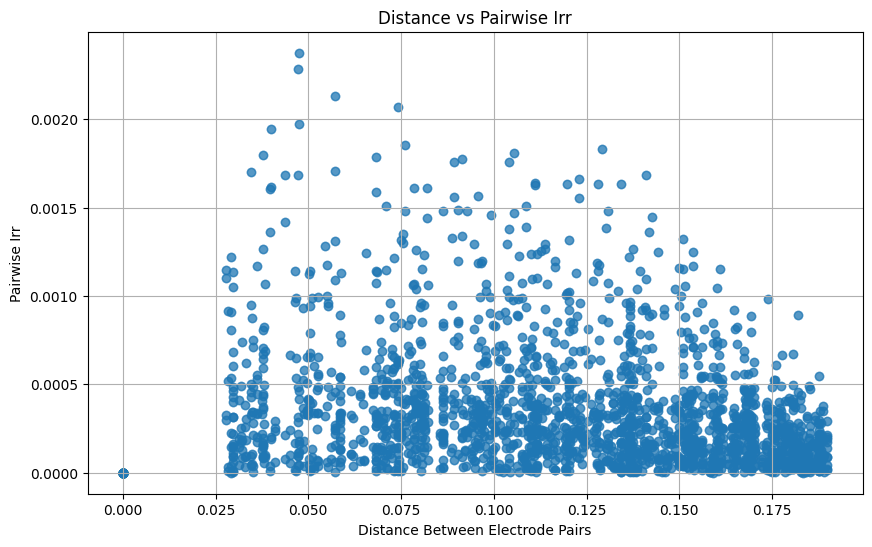

AVERAGE REFMATRIX


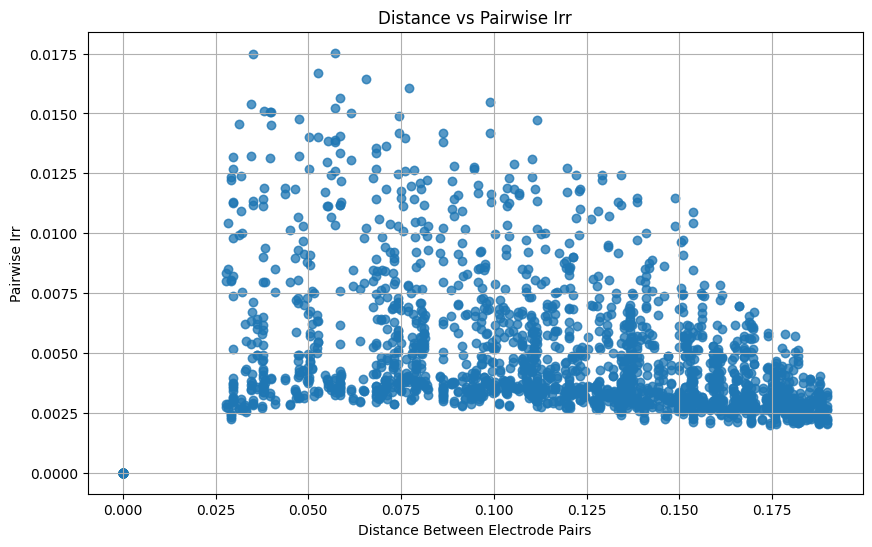

In [16]:
behavior = pd.read_csv(r'C:\Users\jaket\COGS280\DataDeco\behavior.csv', index_col=0).reset_index(drop=True)
Ref_matrices_array = np.load(r'C:\Users\jaket\COGS280\DataDeco\prestimulus_ref_matrices.npy')
behavior['trial'] = behavior.index
list1 = [Ref_matrices_array[i] for i in range(Ref_matrices_array.shape[0])]
behavior['Ref_matrices'] = list1


avg_refmatrix = np.mean(behavior['Ref_matrices'])
correct_df = behavior[(behavior['correct'] == 1)]
mean_correct_refmatrix = np.mean(correct_df['Ref_matrices'])
incorrect_df = behavior[(behavior['correct'] == 0)]
mean_incorrect_refmatrix = np.mean(incorrect_df['Ref_matrices'])

absolute_diff_matrix = np.abs(mean_correct_refmatrix - mean_incorrect_refmatrix)


montage = mne.channels.make_standard_montage('biosemi64')

channel_names = montage.ch_names



# Get the positions of the electrodes
pos = montage.get_positions()['ch_pos']  # This returns a dictionary mapping channel names to 3D positions

positions = np.array(list(pos.values()))

# Calculate the distance matrix
from scipy.spatial import distance_matrix
dist_matrix = distance_matrix(positions, positions)

print(dist_matrix.shape)

print(dist_matrix)

# Flatten the matrices
pairwise_irr = absolute_diff_matrix.flatten()
distance_values = dist_matrix.flatten()

print("ABS DIFF REFMATRIX")
# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(distance_values, pairwise_irr, alpha=0.5)
plt.title('Distance vs Pairwise Irr')
plt.xlabel('Distance Between Electrode Pairs')
plt.ylabel('Pairwise Irr')
plt.grid(True)
plt.show()

print("AVERAGE REFMATRIX")
# Flatten the matrices
pairwise_irr = avg_refmatrix.flatten()
distance_values = dist_matrix.flatten()

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(distance_values, pairwise_irr, alpha=0.5)
plt.title('Distance vs Pairwise Irr')
plt.xlabel('Distance Between Electrode Pairs')
plt.ylabel('Pairwise Irr')
plt.grid(True)
plt.show()

